# Práctica Final Aprendizaje Automático

Grupo 5: Jorge Ortega y Daniela Vidal

## Índice

1. [Presentación del dataset](#Presentación-del-dataset)
2. [Preprocesamiento](#Preprocesamiento)
3. [Dataset final](#Dataset-final)
4. [Separación en entrenamiento, validación y test](#Separación-en-entrenamiento,-validación-y-test)
5. [Regresión logística](#Reg-logística)
6. [Red neuronal](#Red-neuronal)
7. [Árboles de decisión](#Árboles-de-decisión)
8. [Comparación de resultados](#Comparación-de-resultados)
9. [Conclusiones](#Conclusiones)
10. [Bibliografía](#Bibliografía) 

## 1. Presentación del dataset <a class="anchor" id="Presentación-del-dataset"></a>

Esta práctica consiste en la aplicación de los conocimientos adquiridos en la asignatura de Aprendizaje Automático a un dataset sobre reconocimiento de gestos con datos de la actividad muscular. Lo que se pretende es realizar un clasificador que sea capaz de predecir qué gesto se está realizando a partir de los datos de la actividad muscular.

El dataset que hemos elegido para realizar la práctica es el de [Classify gestures by reading muscle activity](https://www.kaggle.com/datasets/kyr7plus/emg-4). Se trata de un dataset de Kaggle que contiene datos de la actividad muscular de 4 gestos diferentes: 
- Piedra (puño)

- Papel (extensión de la mano)

- Tijeras (dedos índice y corazón extendidos)

- Okay (dedo índice tocando el pulgar y el resto de dedos extendidos). 

Los datos se han recogido con señales EMG (electromiografía). Las señales EMG son señales eléctricas que se producen en los músculos cuando estos se activan y se pueden utilizar para detectar y clasificar gestos. Los datos se han recogido con una banda colocada en el brazo con 8 sensores en la superficie de la piel, cada uno de ellos recoge la actividad eléctrica producida por los músculos debajo de la piel. 
Cada línea del dataset consiste en 40ms en las que se hacen 8 medidas consecutivas de los 8 sensores, es decir, 64 columnas en total de esta manera:

                                    [8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][Gesto]

En total hay 120s de cada gesto.

La columna 'Gesto' clasifica piedra - 0, tijeras - 1, papel - 2, okay - 3.

Para asegurarse de la calidad de los datos, se realizaron 6 repeticiones de cada gesto en la que se empezaba y se paraba de medir con el gesto sostenido.

Se trata de 4 datasets de alrededor de 2900 filas cada uno con la actividad de cada gesto. 

Sin embargo hemos decidido usar solo 3 de los 4 datasets, ya que la dimensionalidad de los datos es muy grande y para algunos algoritmos de aprendizaje automático se hace muy tedioso. Por ello hemos decidido usar solo los datos de los gestos de piedra, papel y tijeras.

## 2. Preprocesamiento <a class="anchor" id="Preprocesamiento"></a>

### Imports necesarios:

In [2]:
import hyperopt as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from xgboost import plot_tree

2023-05-14 19:51:20.068073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 19:51:21.850561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 19:51:21.850590: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-14 19:51:24.901070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Constantes globales

In [3]:
RANDOM_STATE = 42

### Lectura del dataset

In [4]:
X0 = pd.read_csv('0.csv')
X1 = pd.read_csv('1.csv')
X2 = pd.read_csv('2.csv')
X3 = pd.read_csv('3.csv')

Podemos ver lo que contienen los datasets en las siguientes tablas:

In [5]:
X0.head()

,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0.3,8.0.1,5.0.1,4.0.4,-7.0.1,-59.0,16.0,0
0,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
1,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
2,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
3,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
4,15.0,-5.0,-5.0,-15.0,12.0,-22.0,-38.0,36.0,9.0,6.0,...,-26.0,5.0,6.0,6.0,11.0,5.0,30.0,-48.0,25.0,0


In [5]:
X1.head()

,-7.0,-1.0,-1.0.1,0.0,-10.0,-10.0.1,-1.0.2,1.0,-5.0,-5.0.1,...,6.0.1,-4.0.6,-3.0.5,-5.0.5,-3.0.6,15.0.1,11.0,-4.0.7,-5.0.6,1
0,-6.0,-2.0,-5.0,-2.0,27.0,42.0,3.0,5.0,11.0,1.0,...,2.0,-17.0,-5.0,-7.0,-2.0,15.0,12.0,0.0,-7.0,1
1,5.0,0.0,-1.0,-2.0,2.0,-9.0,1.0,5.0,1.0,-3.0,...,-11.0,-23.0,1.0,-1.0,-1.0,-23.0,-25.0,2.0,-1.0,1
2,31.0,4.0,2.0,-2.0,38.0,14.0,2.0,7.0,-2.0,4.0,...,-4.0,13.0,2.0,-1.0,-3.0,-7.0,0.0,-3.0,-2.0,1
3,-4.0,-4.0,3.0,3.0,-25.0,-46.0,-1.0,3.0,-7.0,-6.0,...,15.0,4.0,-4.0,-1.0,-1.0,7.0,26.0,3.0,-7.0,1
4,-8.0,-3.0,-1.0,0.0,14.0,5.0,-4.0,-6.0,2.0,0.0,...,-18.0,53.0,8.0,-1.0,-1.0,-2.0,-5.0,-2.0,9.0,1


In [6]:
X2.head()

,4.0,19.0,-9.0,-7.0,-3.0,-36.0,-6.0,-23.0,3.0,-21.0,...,9.0,-14.0.1,-2.0.5,-3.0.3,-4.0,-21.0.1,7.0,-8.0.1,-12.0.2,2
0,-1.0,12.0,20.0,7.0,20.0,-73.0,-4.0,-2.0,4.0,5.0,...,-3.0,-5.0,-2.0,0.0,-4.0,-7.0,5.0,6.0,9.0,2
1,4.0,5.0,-8.0,-2.0,10.0,-10.0,-10.0,16.0,-3.0,-18.0,...,2.0,0.0,2.0,3.0,-8.0,19.0,20.0,0.0,-8.0,2
2,-3.0,-3.0,5.0,11.0,25.0,-20.0,-2.0,14.0,9.0,32.0,...,15.0,-2.0,16.0,6.0,9.0,1.0,31.0,16.0,4.0,2
3,-5.0,-9.0,-2.0,-5.0,-46.0,-34.0,-9.0,-4.0,0.0,8.0,...,-5.0,-11.0,-6.0,7.0,6.0,-10.0,-24.0,-6.0,0.0,2
4,3.0,-3.0,-6.0,-5.0,-3.0,-4.0,-5.0,-4.0,-5.0,8.0,...,-18.0,-14.0,8.0,1.0,-2.0,-4.0,-34.0,-3.0,6.0,2


In [7]:
X3.head()

,-22.0,-9.0,-6.0,-1.0,21.0,26.0,-2.0,5.0,5.0.1,0.0,...,-10.0,-15.0.1,-6.0.3,-3.0.4,3.0.1,20.0,25.0,1.0.5,1.0.6,3
0,-7.0,0.0,1.0,0.0,-13.0,-18.0,0.0,-9.0,-6.0,-2.0,...,-1.0,11.0,-4.0,-5.0,-4.0,3.0,-8.0,-7.0,-3.0,3
1,-6.0,-6.0,-6.0,-8.0,25.0,43.0,-4.0,7.0,6.0,1.0,...,3.0,2.0,1.0,3.0,-1.0,1.0,9.0,4.0,4.0,3
2,2.0,1.0,1.0,1.0,0.0,-23.0,2.0,-6.0,-1.0,-2.0,...,16.0,-3.0,-1.0,-1.0,-3.0,0.0,-3.0,4.0,3.0,3
3,0.0,3.0,4.0,5.0,1.0,25.0,-9.0,0.0,0.0,1.0,...,1.0,6.0,2.0,1.0,-3.0,-20.0,-42.0,-4.0,2.0,3
4,-11.0,-2.0,-5.0,1.0,-7.0,-11.0,-4.0,-23.0,-9.0,0.0,...,-4.0,9.0,1.0,2.0,8.0,21.0,41.0,15.0,9.0,3


Como habíamos comentado, cada dataset tiene 2900 filas, 8 columnas de sensores y una columna de gesto. En este caso, los gestos están codificados como 0, 1 y 2 para piedra, tijeras y papel respectivamente. En el resto de columnas podemos ver datos numéricos que representan la actividad muscular en cada sensor.

In [8]:
print(X0.shape, X1.shape, X2.shape, X3.shape)

(2909, 65) (2902, 65) (2942, 65) (2921, 65)


Como podemos hay más o menos el mismo número de gestos de cada tipo y el mismo número de medidas. Igualmente nos encargaremos del desbalanceo de clases para obtener mejores resultados.

A continuación vamos a comprobar si para cada archivo está correctamente clasificada su clase:

In [9]:
X0.iloc[:,-1].value_counts(), X1.iloc[:,-1].value_counts(), X2.iloc[:,-1].value_counts(), X3.iloc[:,-1].value_counts()

(0    2909
 Name: 0, dtype: int64,
 1    2902
 Name: 1, dtype: int64,
 2    2942
 Name: 2, dtype: int64,
 3    2921
 Name: 3, dtype: int64)

Comprobaremos también que no hay valores nulos en los datasets:

In [10]:
X0.isna().sum().sum(), X1.isna().sum().sum(), X2.isna().sum().sum(), X3.isna().sum().sum()

(0, 0, 0, 0)

Ahora que hemos comprobado que los datos están bien clasificados y no hay valores nulos, vamos a unir los 4 datasets en uno solo para poder trabajar con todos los datos a la vez:

In [6]:
allFiles=['0.csv','1.csv','2.csv', '3.csv']

list = []
for file in allFiles:
    read = pd.read_csv(file, header = None)
    list.append(read)
data = pd.concat(list)


In [7]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


Por otro lado podemos ver como los rangos de los datos son relativamente diferentes, por lo que tendremos que escalarlos para que no haya problemas a la hora de entrenar los modelos.

In [8]:
def scale(X):
    x = X.iloc[:, :-1].values
    s = StandardScaler()
    x_scaled = s.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled, columns=X.columns[:-1]) #La columna de la clase no se escala
    df_scaled[X.columns[-1]] = X[X.columns[-1]].values
    return df_scaled

In [9]:
X_scal = scale(data)

## 3. Dataset final <a class="anchor" id="Dataset-final"></a>

El dataset final que vamos a utilizar para entrenar los modelos es el siguiente:

In [15]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


In [16]:
data.shape

(11678, 65)

Es decir 11678 filas y 65 columnas.

In [17]:
data.iloc[:,-1].value_counts()

2    2943
3    2922
0    2910
1    2903
Name: 64, dtype: int64

## 4. Separación en entrenamiento, validación y test <a class="anchor" id="Separación-en-entrenamiento,-validación-y-test"></a>

Deberemos dividir de manera distinta para los modelos de clasificación y los de regresión. Para los modelos de clasificación, dividiremos en entrenamiento, validación y test, mientras que para los de regresión, dividiremos en entrenamiento y test. Además para el de regresión usaremos dos el dataset de piedra y el de tijeras de manera que haya dos posibles salidas y podamos aplicar la función sigmoide para calcular la probabilidad de que sea una u otra, mientras que para el de clasificación usaremos todos los gestos.

#### Regresión

Primero sacaremos los datos de piedra y tijeras para el modelo de regresión:

In [10]:
allFiles=['0.csv','1.csv']

list = []
for file in allFiles:
    read = pd.read_csv(file, header = None)
    list.append(read)
data_reg = pd.concat(list)

Los normalizamos:

In [19]:
X_reg_scal = scale(data_reg)

In [20]:
X_R = X_reg_scal.iloc[:, :-1].values
y_R = X_reg_scal.iloc[:, -1].values

Y los dividimos en entrenamiento y test (70-30):

In [21]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_R, y_R, test_size=0.30, random_state=RANDOM_STATE, stratify=y_R)

In [22]:
X_trainR.shape, X_testR.shape

((4069, 64), (1744, 64))

#### Clasificación

Dividiremos en 60-20-20 para entrenamiento, test y validación. Aunque las clases están balanceadas, utilizaremos la función de sklearn para asegurarnos de que se mantienen las proporciones de cada clase en cada conjunto.

In [11]:
X_train, X, y_train, y = train_test_split(X_scal.iloc[:, :-1], X_scal.iloc[:, -1],test_size=0.4, random_state=RANDOM_STATE, stratify=X_scal.iloc[:, -1])
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE, stratify=y)

In [12]:
X_train.shape, X_val.shape, X_test.shape

((7006, 64), (2336, 64), (2336, 64))

# 5. Regresión logística <a class="anchor" id="Reg-logística"></a>

Primero estudiaremos los datos para ver cómo de fuerte es la correlación entre las variables, esto es la relación lineal existente entre ellas, y si hay alguna que no aporta información. 

Para ello usaremos la matriz de correlación ya que son demasiados valores para verlos en una tabla:

<Axes: >

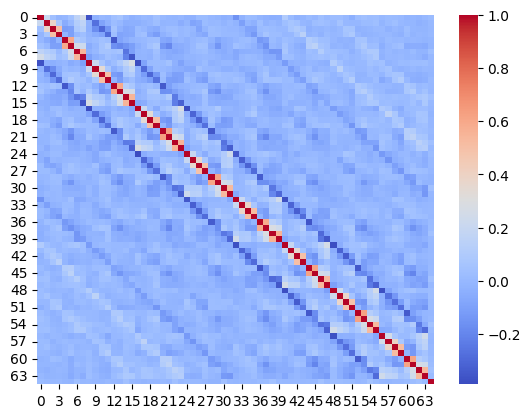

In [25]:
corr_matrix = X_reg_scal.corr()
corr_matrix.to_csv('corr_matrix.csv', index=False)
sns.heatmap(corr_matrix, cmap='coolwarm')

Podemos observar aquí que el único caso en el que tenemos un color rojo (1.0 en correlación) es en la diagonal lo cual es evidente ya que una variable está correlacionada consigo misma. Esto nos indica que no hay variables que estén linealmente relacionadas entre sí y que todas aportan información. La máxima correlación que tenemos es de 0.6 en menos de 10 variables (lo que se puede ver de color más clarito, esto se puede comprobar em corr_matrix.csv) pero en general se pueden ver colores más oscuros, lo cual indica que la correlación es baja. Esto nos indica que no es una relación lineal fuerte y por tanto puede ser no lineal así que mapearemos los datos a un espacio de mayor dimensión para ver si podemos separarlos linealmente.

#### Constantes:

In [26]:
iteraciones = 20
degree = 2

#### Funciones necesarias para la regresión logística:

Mapeo de los atributos:
Hemos visto que las variables no presentan una correlación muy fuerte entre ellas, no obstante puede ser que presenten una relación no lineal entre ellas. Por ello, vamos a mapear los atributos a un espacio de mayor dimensión para ver si así se puede obtener un mejor resultado. Usaremos la función PolynomialFeatures de sklearn.

In [125]:
def map_features(X, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    return X_poly

1. Cálculo de la función de coste y su gradiente

Definición de la función sigmoide a la que se le pasa el vector w, el valor de b y el vector x y se hace el producto escalar para calcular z.

In [28]:
def func_sigmoide(x, w, b):
    z = np.dot(x,w)+b
    return 1/(1+np.exp(-z))

Función que devuelve la predicción según el modelo entrenado.

In [29]:
def predict(X, w, b, degree):
    XX = map_features(X, degree)
    y_hat= func_sigmoide(XX, w, b)
    y_hat = np.where(y_hat >= 0.5, 1, 0)
    return y_hat

Función de coste regularizada: (siendo θ nuestro w,b)

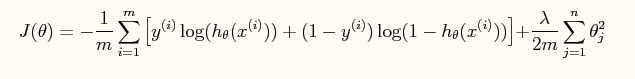

*Figura 1: Función de coste regularizada*

In [30]:
def func_coste(X, Y, w, b, L):
    m = len(Y)
    f = func_sigmoide(X, w, b)
    coste = (-1/m)*np.sum(Y*np.log(f)+(1-Y)*np.log(1-f))
    coste += (L/(2*m))*np.sum(w**2)
    return coste

La función del cálculo de gradiente con regularización es:

Para w:

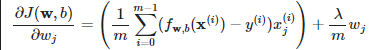

Para b:

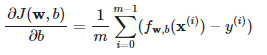

*Figuras 2 y 3: Gradiente de la función de coste regularizada*


In [31]:
def funcion_grad(X, y, w, b, L):
    m = X.shape[0] #antes len(y)
    gw = np.zeros(w.shape)
    gb = 0
    y_hat = func_sigmoide(X, w, b)
    dif = y_hat-y
    
    gb = np.sum(dif)/m                                    
    gw = (1/m) * np.dot(dif,X) + L*w/m
    
    return gw, gb

In [32]:
def funcion_grad_desc(X, y, w, b, alpha, num_iter, L):   
    for i in range(num_iter):
        gw, gb = funcion_grad(X, y, w, b, L)
        w = w - alpha*gw
        b = b - alpha*gb
    return w, b

## Adaptación

Vamos a adaptar nuestros datos ya que, como ya ha sido mencionado, no son linealmente separables. Para ello vamos a usar la función PolynomialFeatures de sklearn que nos permite mapear los atributos a un espacio de mayor dimensión. En este caso, vamos a probar a mapearlos con grado 2. Elegimos este grado ya que si lo ponemos más alto, el tiempo de ejecución se dispara y el gasto en memoria es enorme y no obtenemos mejores resultados. (Si lo hacemos de grado 3 en vez de 2144 columnas tenemos 278401)

In [33]:
XX_train = map_features(X_trainR, degree)
XX_train.shape

(4069, 2144)

## Ajuste

Haremos una regresión logística con regularización, para ello probaremos con diferentes valores de lambda y veremos cuál es el que mejor resultado nos da. 
Los valores que vamos a probar son:

Lambda: 0.1, 1, 2, 4, 6, 8, 10

Alpha: 0.001, 0.01, 0.1

Por último las iteraciones las establecemos en 100, ya que con más iteraciones el tiempo de ejecución se dispara además de que se produce sobreajuste.

In [34]:
def regresion_logistica(X, y, alpha, num_iter, L):
    w, b = funcion_grad_desc(X, y, np.zeros(X.shape[1]), 0, alpha, num_iter, L)
    return w, b

In [35]:
Ls = [0.001, 0.1, 1, 10, 50, 100]
alphas = [0.1, 0.01, 0.001]

train_acc = []
test_acc = []
for l in Ls:
    print ("Lambda: ", l)
    train_list = []
    test_list = []
    for a in alphas:
        w, b = regresion_logistica(XX_train, y_trainR, a, iteraciones, l)
        
        y_hat_train = predict(X_trainR, w, b, degree)
        train = np.mean(y_hat_train == y_trainR)*100
        
        y_hat = predict(X_testR, w, b, degree)
        test = np.mean(y_hat == y_testR)*100
        
        print ("    Alpha: ", a, "Train: ", train, "Test: ", test)
        train_list.append(train)
        test_list.append(test)
    
    train_acc.append(train_list)
    test_acc.append(test_list)  

Lambda:  0.001
    Alpha:  0.1 Train:  99.65593511919391 Test:  99.2545871559633
    Alpha:  0.01 Train:  98.84492504300812 Test:  98.5091743119266
    Alpha:  0.001 Train:  91.79159498648316 Test:  91.05504587155964
Lambda:  0.1
    Alpha:  0.1 Train:  99.65593511919391 Test:  99.2545871559633
    Alpha:  0.01 Train:  98.84492504300812 Test:  98.5091743119266
    Alpha:  0.001 Train:  91.79159498648316 Test:  91.05504587155964
Lambda:  1
    Alpha:  0.1 Train:  99.65593511919391 Test:  99.2545871559633
    Alpha:  0.01 Train:  98.84492504300812 Test:  98.5091743119266
    Alpha:  0.001 Train:  91.79159498648316 Test:  91.05504587155964
Lambda:  10
    Alpha:  0.1 Train:  99.65593511919391 Test:  99.2545871559633
    Alpha:  0.01 Train:  98.84492504300812 Test:  98.5091743119266
    Alpha:  0.001 Train:  91.79159498648316 Test:  91.05504587155964
Lambda:  50
    Alpha:  0.1 Train:  99.65593511919391 Test:  99.31192660550458
    Alpha:  0.01 Train:  98.84492504300812 Test:  98.509174311

Podemos ver que la regularización apenas tiene efecto en el modelo, esto se puede deber a que el modelo obtiene un buen resultado tanto en entrenamiento como en test y no necesita una medida extra para evitar el sobreajuste. No obstante, podemos ver que entre alpha=0.1 y alpha=0.01 hay una diferencia mínima en las precisiones de entrenamiento y test, por lo que elegiremos alpha=0.1 ya que es el que mejor resultado nos da.

Por otro lado podemos ver que el modelo se ajusta muy bien a los datos de entrenamiento y test, aunque la precisión de test es ligeramente menor que la de entrenamiento, que es normal. Por tanto, podemos decir que el modelo no sufre de sobreajuste.

Podemos comparar estos resultados con los obtenidos con el método de sklearn:

In [36]:
regresion = LogisticRegression(penalty='l1', solver='liblinear')

regresion.fit(XX_train, y_trainR)

y_pred = regresion.predict(map_features(X_testR, degree))

accuracy = regresion.score(map_features(X_testR, degree), y_testR)
print("Precisión: ", accuracy)


Precisión:  0.9942660550458715


En este caso hemos hecho un modelo con regularización L1 a través del parámetro penalty = 'l1', a diferencia de la regulrización que estabamos usando antes esta regularización fuerza a que algunos atributos sean 0 y por tanto no se tengan en cuenta. En este caso, podemos ver que el modelo obtiene un resultado muy similar al nuestro. En ambos casos el modelo no sufre de sobreajuste y obtiene un resultado muy bueno tanto en entrenamiento como en test.

4. Pintamos la curva de aprendizaje según los distintos valores de lambda con sus valores de alpha:

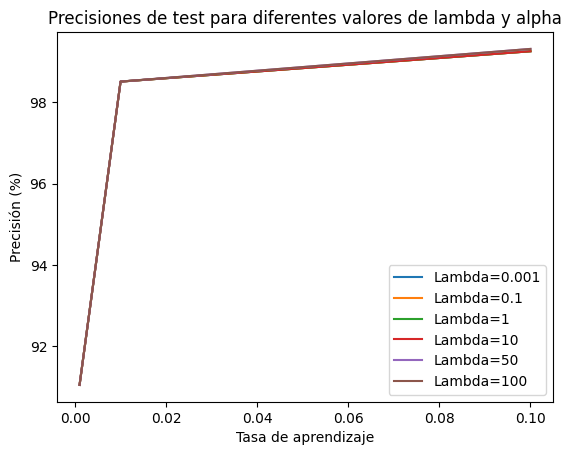

In [37]:
for i in range(len(Ls)):
    plt.plot(alphas, test_acc[i], label='Lambda='+str(Ls[i]))

plt.xlabel('Tasa de aprendizaje')
plt.ylabel('Precisión (%)')
plt.title('Precisiones de test para diferentes valores de lambda y alpha')
plt.legend()
plt.show()


Analizando los resultados, podemos observar que para todos los valores de lambda y alpha, el modelo presenta un alto rendimiento con los datos de entrenamiento, con una precisión cercana al 100%. Además, en el conjunto de prueba, los resultados apenas difieren y en general, la precisión es practicamente igual que en el conjunto de entrenamiento.

Por otro lado, al variar el valor de lambda no se aprecia una mejora en el rendimiento del modelo, lo cual sugiere que la regularización no es necesaria para nuestros datos. En cuanto a la tasa de aprendizaje, se puede observar que el mejor rendimiento se obtiene con un valor de alpha de 0.1, aunque la diferencia en la precisión entre los diferentes valores de alpha es muy pequeña.

En general, estos resultados sugieren que el modelo de regresión logística es capaz de ajustarse adecuadamente a los datos de entrenamiento.


## Resultados

El modelo de regresión logística con regularización es el siguiente:

In [127]:
lambda_reg = 0 
alpha_reg = 0.1
degree = 2

Ya hemos visto que la regularización apenas tiene efecto en el modelo, esto se puede deber a que el modelo obtiene un buen resultado tanto en entrenamiento como en test y no necesita una medida extra para evitar el sobreajuste. No obstante, podemos ver que entre alpha=0.1 y alpha=0.01 hay una diferencia mínima en las precisiones de entrenamiento y test, por lo que elegiremos alpha=0.1 ya que es el que mejor resultado nos da.

In [39]:
w, b = regresion_logistica(XX_train, y_trainR, alpha_reg, iteraciones, lambda_reg)
        
y_hat_train = predict(X_trainR, w, b, degree)
y_hat = predict(X_testR, w, b, degree)

print("Precisión de entrenamiento: ", np.mean(y_hat_train == y_trainR)*100, "%")
y_hat = predict(X_testR, w, b, degree)
print("Precisión de test: ", np.mean(y_hat == y_testR)*100, "%")

Precisión de entrenamiento:  99.65593511919391 %
Precisión de test:  99.2545871559633 %


Obtenemos una precisión de 99.65% en entrenamiento y 99.25% en test. Estos resultados son muy buenos y podemos deducir de los datos que no las variables presentan una relación no lineal entre ellas. Esto lo sabemos porque hemos mapeado los datos a un espacio de mayor dimensión y hemos obtenido un resultado muy bueno ya que si se hace sin mapearlos se obtiene como mucho un 60% de precisión. De cualquier manera esto se podía intuir ya que en la matriz de correlación no se veían variables que estuvieran linealmente relacionadas entre sí.  

## Estudio de la precisión

Podemos ver la matriz de confusión para ver cómo de bien clasifica el modelo:

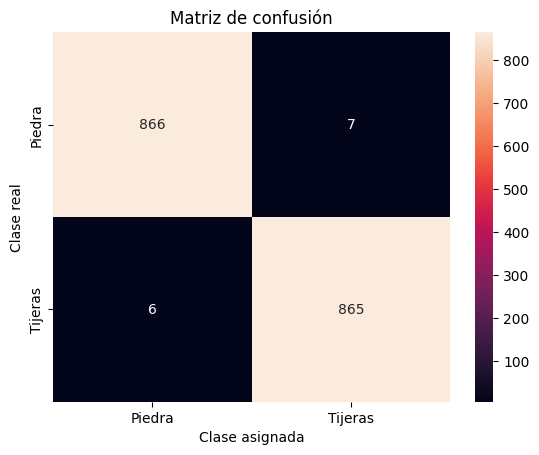

In [40]:
f,ax = plt.subplots()
labels = ["Piedra", "Tijeras"]
matriz_conf = confusion_matrix(y_testR,y_hat)
sns.heatmap(matriz_conf, annot=True, ax=ax, fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel("Clase asignada")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.show()

Esta matriz muestra la cantidad de verdaderos Piedra y Tijeras que se han clasificado correctamente y los falsos Piedra y Tijeras que se han clasificado incorrectamente. Podemos ver que el modelo clasifica muy bien los datos, ya que solo se han clasificado incorrectamente 6 Piedra y 7 Tijeras de 1744.



Por otro lado podemos ver la precisión, recall y f1-score para cada clase:

In [41]:
print(classification_report(y_testR, y_hat))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       873
           1       0.99      0.99      0.99       871

    accuracy                           0.99      1744
   macro avg       0.99      0.99      0.99      1744
weighted avg       0.99      0.99      0.99      1744



Aquí podemos ver información sobre la precisión, el recall y F1-score para cada clase y su media ponderada. En este caso, para ambas clases se obtiene una precisión del 99% lo que muestra que el modelo ha tenido una tasa muy baja de falsos Piedra y de falsos Tijeras. El recall también es de 99% lo que nos indica que el modelo ha sido capaz de recuperar la gran mayoría de '1' es decir, tijeras y por tanto ha tenido una tasa muy baja de falsos negativos. Por último, el F1-score es de 99% lo que nos indica que el modelo ha tenido un buen balance entre precisión y recall.

La media de estas metricas es, por tanto, del 99% lo que nos indica que el modelo entrenado con regresión logística ha tenido un buen rendimiento general.

# 6. Red neuronal multiclase <a class="anchor" id="Red-neuronal"></a> 

Vamos a desarrollar una red neuronal para clasificar los gestos. Exploraremos el proceso de construcción, entrenamiento y evaluación de una red neuronal multicapa. Para ello usaremos la librería Keras de Tensor Flow.

En este caso ya usaremos los cuatro gestos para entrenar el modelo cuyo objetivo es clasificarlo en uno de estos, por lo que usaremos el dataset de clasificación. 

Se trata de un problema de clasificación multiclase, por lo que usaremos:
- **Función de activación softmax** en la capa de salida. Esta función es una generalización de la función sigmoide para más de dos clases la cual devuelve un vector de probabilidades de que la entrada pertenezca a cada una de las clases (una distribución de probabilidad). 
- **Optimizador Adam**, el cual utiliza una tasa de aprendizaje adaptativa para cada parámetro en lugar de una global y que, además, es una buena opción por su eficiencia computacional y su capacidad para manejar problemas con muchos datos y parámetros. 
- La función de coste que usaremos será la **entropía cruzada categórica**, la cual es la más utilizada para problemas de clasificación multiclase.
- Por último, en las capas ocultas usaremos la función de **activación ReLU**, la cual es la más utilizada en redes neuronales ya que es muy eficiente computacionalmente.

Los datos de entrada son los valores de los sensores y la salida es un vector de 4 posiciones con la probabilidad de que la entrada pertenezca a cada una de las clases.

Estos datos están ya normalizados y divididos en entrenamiento, validación y test. Recordemos qué datos tenemos:

In [42]:
X_train.shape, X_val.shape, X_test.shape

((7006, 64), (2336, 64), (2336, 64))

En total tenemos 7006 datos de entrenamiento, 2336 de validación y 2336 de test. Además son 64 columnas, es decir, la cantidad de datos de entrenamiento es bastante alta, por lo que usaremos un modelo complejo con regularización.

Modelo con 150 unidades en la primera capa, 50 en la segunda y 4 en la de salida:

## Adaptación

Al igual que hicimos en la regresión logística, vamos a mapear los datos a un espacio de mayor dimensión ya que esto ha dado un buen resultado en la regresión y al final cada neurona de una red neuronal aplica el mismo método. Para ello usaremos la función PolynomialFeatures de sklearn:

In [130]:
degree = 2

In [128]:
XX_train = map_features(X_train, degree)
XX_val = map_features(X_val, degree)
XX_test = map_features(X_test, degree)

In [131]:
XX_train.shape, XX_val.shape, XX_test.shape

((7006, 2144), (2336, 2144), (2336, 2144))

## Ajuste

Ajustaremos los hiperparámetros del modelo usando la optimización bayesiana. Para ello usaremos la librería hyperopt.

Los hiperparámetros que vamos a ajustar son:

- **Tasa de aprendizaje** que es la tasa de aprendizaje del optimizador Adam
- **Número de neuronas** en la capa oculta
- **Número de iteraciones** que es el número de veces que se entrena el modelo
- **Regularización** que es el parámetro alpha de la regularización L2
- **Tamaño del batch** que es el número de muestras que se usan para calcular el error y actualizar los pesos
- **Número de capas ocultas** que es el número de capas ocultas de la red neuronal

Establecemos el espacio de búsqueda de los hiperparámetros:

In [150]:
spaceRN ={
    'neurons': hp.quniform('neurons', 20, 150, 1),
    'learning_rate':hp.uniform('learning_rate', 0.001, 1.0),
    'batch_size':hp.quniform('batch_size', 128, 3000, 1),
    'epochs': 150,
    'layers' : hp.quniform('layers', 1, 3, 1),
    'lmda' : hp.uniform('lmda', 0.001, 0.1),
}

Y definimos la función objetivo que es la que se va a optimizar:

In [155]:
def objectiveRN(space):
    model = Sequential()
    model.add(Dense(int(space['neurons']), activation='relu', input_dim=XX_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(space['lmda'])))
    
    for i in range(int(space['layers'])):
        model.add(Dense(int(space['neurons']), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(space['lmda'])))
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)    
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(learning_rate= space['learning_rate']), metrics=['accuracy'])
    model.fit(XX_train, y_train, validation_data = (XX_val, y_val), callbacks=[es], batch_size=int(space['batch_size']), epochs=int(space['epochs']), verbose=0)
    
    accuracy = model.evaluate(XX_test, y_test, verbose=0)[1]
    
    return{'loss': -accuracy, 'status': STATUS_OK }

El objetivo es maximizar la precisión en test. Además, se ha añadido un early stopping para que el modelo pare de entrenar cuando el error en validación no mejore en 20 iteraciones.

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objectiveRN, space = spaceRN, algo = tpe.suggest, max_evals = 30, trials = trials)

Esto son los resultados de la búsqueda de hiperparámetros:

In [157]:
best_hyperparams

{'batch_size': 2040.0,
 'layers': 3.0,
 'learning_rate': 0.0023840711256595815,
 'lmda': 0.021679683932102747,
 'neurons': 120.0}

In [159]:
best_batch_size = round(best_hyperparams['batch_size'])
best_epochs = 150
best_learning_rate = best_hyperparams['learning_rate']
best_neurons = round(best_hyperparams['neurons'])
best_layers = round(best_hyperparams['layers'])
best_lmda = best_hyperparams['lmda']

(Para no tener que volver a ejecutarlo)

In [163]:
best_batch_size = 2040
best_epochs = 150
best_learning_rate = 0.0023840711256595815
best_neurons = 120
best_layers = 3
best_lmda = 0.021679683932102747

Entrenamos el modelo según estos parámetros y vemos las curvas de aprendizaje para establecer el mejor valor de iteraciones:

In [164]:
modelo = Sequential()

modelo.add(Dense(best_neurons, input_dim=XX_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(best_lmda)))
for i in range(best_layers):
    modelo.add(Dense(best_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(best_lmda)))
modelo.add(Dense(4, activation='softmax'))

modelo.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(best_learning_rate), metrics=['accuracy'])

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)

history = modelo.fit(XX_train, y_train, validation_data=(XX_val, y_val), epochs=best_epochs, batch_size=best_batch_size, verbose=0, callbacks=[es])

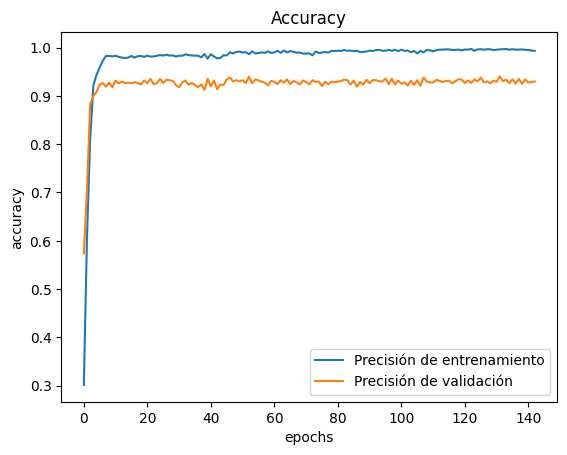

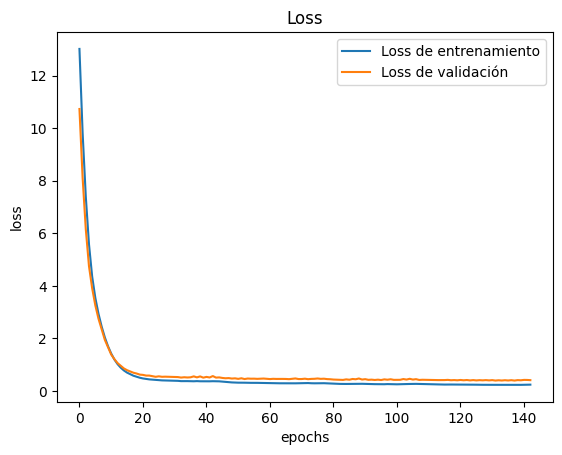

In [165]:
plt.figure(0)

plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='Loss de entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de validación')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Podemos ver que 40 iteraciones es un buen valor ya que la función de coste de entrenamiento y de validación se estabilizan y no hay sobreajuste. Lo mismo ocurre con la precisión. Podríamos establecerlo más bajo pero ya que vamos a usar early stopping el modelo para antes de llegar a 40 iteraciones si no mejora.

In [195]:
best_epochs = 40

## Red neuronal con mejor resultado:

In [196]:
modelo = Sequential()

modelo.add(Dense(best_neurons, input_dim=XX_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(best_lmda)))
for i in range(best_layers):
    modelo.add(Dense(best_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(best_lmda)))
modelo.add(Dense(4, activation='softmax'))

modelo.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(best_learning_rate), metrics=['accuracy'])

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=10)

history = modelo.fit(XX_train, y_train, validation_data=(XX_val, y_val), epochs=best_epochs, batch_size=best_batch_size, verbose=0, callbacks=[es])

Esta es la precisión de entrenamiento, test y evaluación para cada iteración:

In [197]:
score = modelo.evaluate(XX_test, y_test, verbose=0)
print('Precisión en el conjunto de test:', score[1]*100 ,'%')

Precisión en el conjunto de test: 91.99486374855042 %


In [198]:
score = modelo.evaluate(XX_train, y_train, verbose=0)
print('Precisión en el conjunto de entrenamiento:', score[1]*100 ,'%')

Precisión en el conjunto de entrenamiento: 98.60119819641113 %


In [199]:
score = modelo.evaluate(XX_val, y_val, verbose=0)
print('Precisión en el conjunto de validación:', score[1]*100 ,'%')

Precisión en el conjunto de validación: 92.67979264259338 %


## Estudio de la precisión:


Obtenemos la predicción para los datos de test:

In [200]:
Y_hat = modelo.predict(XX_test)
Y_hat_clases = np.argmax(Y_hat,axis = 1)

73/73 [==============================] - 0s 3ms/step


Primero veremos las medidas de calidad respecto a los datos de entrenamiento (métricas de entrenamiento):
- Precision: fracción de predicciones correctas que el modelo ha hecho
- Recall: fracción de ejemplos positivos que el modelo ha predicho correctamente
- F1-score: medida de la precisión y exhaustividad del modelo

In [201]:
cr = classification_report(y_test, Y_hat_clases)
print (cr)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       582
           1       0.92      0.97      0.94       581
           2       0.93      0.87      0.90       589
           3       0.85      0.93      0.89       584

    accuracy                           0.92      2336
   macro avg       0.92      0.92      0.92      2336
weighted avg       0.92      0.92      0.92      2336



Podemos ver también cómo de bien clasifica cada clase con la matriz de confusión:

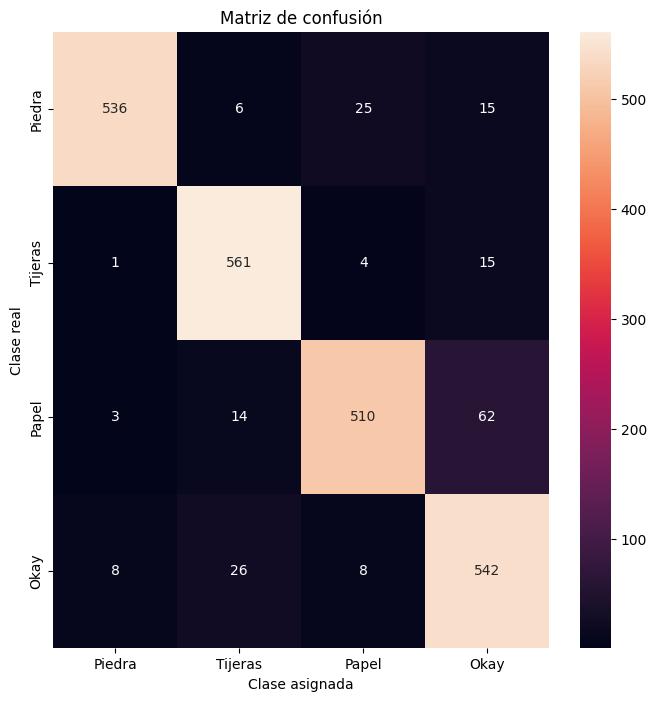

In [202]:
confusion_mtx = confusion_matrix(y_test, Y_hat_clases) 
labels = ["Piedra", "Tijeras", "Papel", "Okay"]

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, ax=ax, fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel("Clase asignada")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.show()

# 7. Árboles de decisión <a class="anchor" id="Árboles-de-decisión"></a>

## 7.1 Árbol de decisión para clasificación multiclase con scikit learn <a class="anchor" id="Árbol-de-decisión-para-clasificación-binaria"></a>

En primer lugar vamos a desarrollar un árbol de decisión para clasificar los gestos. Exploraremos el proceso de construcción, entrenamiento y evaluación de un árbol de decisión. Para ello usaremos la librería scikit learn. 

Tenemos 64 columnas, es decir, la cantidad de datos de entrenamiento es bastante alta, por lo que vamos a agrupar los datos en 8 columnas según el sensor que los ha recogido. De esta forma, cada columna representará la media de los datos de cada sensor. 

### 7.1.1 Adaptación

In [289]:
sensor_names = [f'Sensor {i}' for i in range(8)]
classes_names = ['Piedra', 'Tijeras', 'Papel', 'Okay']

In [290]:
df_sensores = pd.DataFrame(columns=sensor_names)

data_x = data.drop([64], axis=1)
#data_x = data.iloc[:, :8]
# asumiendo que 'df' es tu DataFrame con las 64 columnas
cols = data_x.columns.tolist()

# seleccionar las columnas con resto i al dividir por 8 para tener cada sensor en un array
for i in range(8):
    cols_i = [col for col in cols if cols.index(col) % 8 == i]
    suma_columna = data_x[cols_i].median(axis=1)               #Probar si es mejor sumar o hacer la media
    df_sensores[f'Sensor {i}'] = suma_columna
    

In [291]:
df_sensores['Clase'] = data[64]
df_sensores.head()

,Sensor 0,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Clase
0,8.000,1.500,0.875,0.500,-2.125,-4.750,-48.000,-9.375,0
1,-2.875,0.000,1.125,0.500,4.875,6.375,4.250,-3.750,0
2,-5.250,-1.750,-2.750,-2.875,-1.375,-5.625,-13.750,0.250,0
3,-2.375,-0.625,-0.375,-0.125,3.375,4.500,9.000,-2.500,0
4,-6.000,-0.625,0.375,0.500,-2.875,-2.875,-32.125,-7.000,0


In [292]:
df_sensores.shape

(11678, 9)

In [304]:
df_sensores.groupby(['Clase']).describe()

Sensor 0                                                           \
         count      mean       std     min    25%    50%    75%     max   
Clase                                                                     
0       2910.0 -0.841838  3.807162 -26.375 -3.000 -0.875  1.250  16.125   
1       2903.0 -0.685756  3.122688 -11.875 -2.750 -0.750  1.250  12.375   
2       2943.0 -0.661145  3.670574 -16.375 -2.875 -0.750  1.500  19.750   
3       2922.0 -0.681639  2.332989 -11.125 -2.125 -0.750  0.625   8.250   

      Sensor 1            ... Sensor 6         Sensor 7                      \
         count      mean  ...      75%     max    count      mean       std   
Clase                     ...                                                 
0       2910.0 -0.741967  ...  2.21875  24.875   2910.0 -0.843814  4.224756   
1       2903.0 -0.750689  ... -0.25000  11.000   2903.0 -0.706683  1.659347   
2       2943.0 -0.714704  ...  0.12500   6.125   2943.0 -0.712326  2.782897   
3       2922.0 -0.746663  ...  0.25000   8.875   2922.0 -0.712568  2.535676   

                                          
          min   25%    50%   75%     max  
Clase                                     
0     -24.375 -3.00 -0.875  1.50  19.125  
1      -6.875 -1.75 -0.750  0.25   6.750  
2     -11.375 -2.50 -0.750  1.00   9.750  
3     -13.375 -2.25 -0.750  0.75  12.125  

[4 rows x 64 columns]

Separamos en train, test y validación:

In [305]:
XT_train, XT, yt_train, yt = train_test_split(df_sensores.drop(['Clase'], axis=1), df_sensores['Clase'], test_size=0.4, random_state=RANDOM_STATE)
XT_val, XT_test, yt_val, yt_test = train_test_split(XT, yt, test_size=0.5, random_state=RANDOM_STATE)

In [306]:
XT_train.shape, XT_val.shape, XT_test.shape, yt_train.shape, yt_val.shape, yt_test.shape

((7006, 8), (2336, 8), (2336, 8), (7006,), (2336,), (2336,))

### 7.1.2 Ajuste

Los parámetros que vamos a ajustar son:

- **Profundidad máxima** que es la profundidad máxima del árbol
- **Número mínimo de muestras** que es el número mínimo de muestras necesarias para dividir un nodo
- **Criterion** que es la función de calidad de la división

In [307]:
criterion = ['gini', 'entropy']
max_depths = [2, 3, 4, 5, 7, 10]
min_samples_split = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

Probamos con distintos valores para cada uno de ellos y nos quedamos con el que mejor resultado nos de:

In [312]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=0.001)

for mss in min_samples_split:
    for md in max_depths:
        for crit in criterion:
            clf = DecisionTreeClassifier(criterion=crit, max_depth = md, min_samples_split=mss, random_state=RANDOM_STATE)
            clf = clf.fit(XT_train, yt_train)

            train_accuracy = clf.score(XT_train, yt_train)
            test_accuracy = clf.score(XT_val, yt_val)

            print("Mss ", mss, "Md ", md, "Crit ", crit, "TrAcc ", train_accuracy, "TsAcc ", test_accuracy)

Mss  0.05 Md  2 Crit  gini TrAcc  0.40565229803025976 TsAcc  0.4169520547945205
Mss  0.05 Md  2 Crit  entropy TrAcc  0.41021981159006565 TsAcc  0.4246575342465753
Mss  0.05 Md  3 Crit  gini TrAcc  0.47316585783614046 TsAcc  0.4777397260273973
Mss  0.05 Md  3 Crit  entropy TrAcc  0.4771624322009706 TsAcc  0.4858732876712329
Mss  0.05 Md  4 Crit  gini TrAcc  0.5508135883528404 TsAcc  0.540667808219178
Mss  0.05 Md  4 Crit  entropy TrAcc  0.553811019126463 TsAcc  0.5500856164383562
Mss  0.05 Md  5 Crit  gini TrAcc  0.584070796460177 TsAcc  0.5710616438356164
Mss  0.05 Md  5 Crit  entropy TrAcc  0.5879246360262632 TsAcc  0.577054794520548
Mss  0.05 Md  7 Crit  gini TrAcc  0.6287467884670283 TsAcc  0.6091609589041096
Mss  0.05 Md  7 Crit  entropy TrAcc  0.6244647445047102 TsAcc  0.6095890410958904
Mss  0.05 Md  10 Crit  gini TrAcc  0.6493005994861547 TsAcc  0.6190068493150684
Mss  0.05 Md  10 Crit  entropy TrAcc  0.6435912075363974 TsAcc  0.6220034246575342
Mss  0.1 Md  2 Crit  gini TrAcc  

Uno de los mejores resultados lo obtenemos con una profundidad máxima de 10, un número mínimo de muestras del 30% y criterio gini. Para este modelo obtenemos una precisión de entrenamiento de 0.6284 y una precisión de test de 0.6130.
Lo cual no es un mal resultado pero no es ideal, por lo que en el siguiente apartado vamos a probar con otro modelo más complejo.

Mss  0.2 Md  10 Crit  gini TrAcc  0.6284613188695404 TsAcc  0.613013698630137

In [313]:
best_md = 10
bes_mss = 0.2
best_crit = 'gini'

### 7.1.3 Árbol de decisión con mejor resultado:

In [315]:
clf = DecisionTreeClassifier(criterion=best_crit, max_depth = best_md, min_samples_split=bes_mss, random_state=RANDOM_STATE, ccp_alpha=0.001)
clf = clf.fit(XT_train, yt_train)

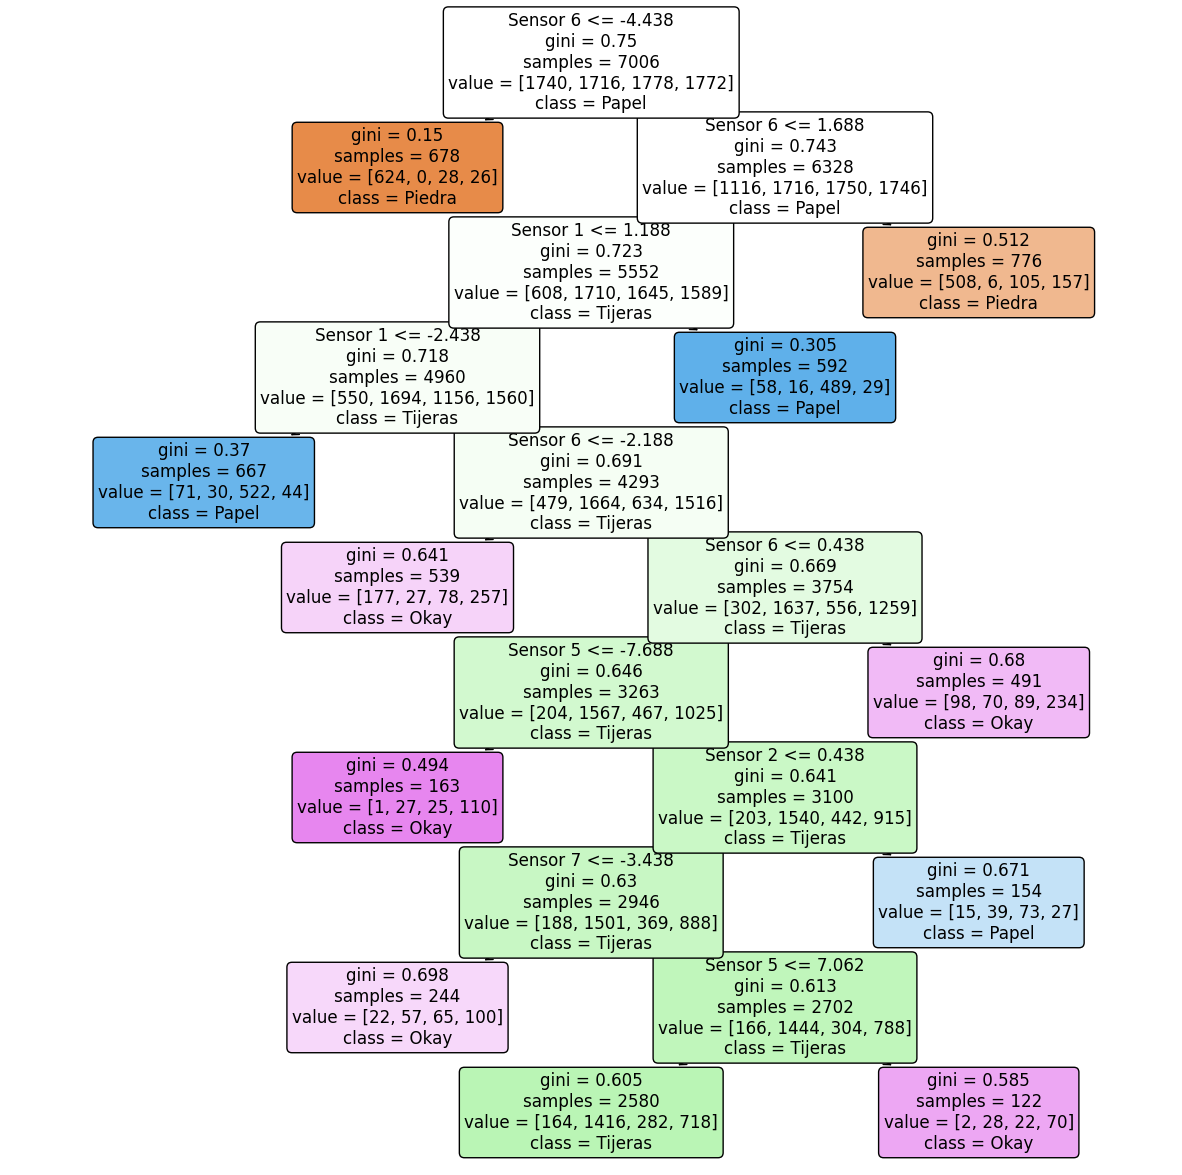

In [316]:
plt.figure(figsize=(15,15))
plot_tree(clf, filled=True, feature_names= sensor_names, class_names=classes_names, rounded=True)
plt.show()

## 7.2 Árbol de decisión con XGBoost <a class="anchor" id="Árbol-de-decisión-con-XGBoost"></a>

Para este dataset debido a la gran cantidad de datos que tenemos, vamos a usar el modelo de XGBoost (eXtreme Gradient Boosting). Este modelo es un algoritmo de aprendizaje supervisado que se utiliza para problemas de clasificación y regresión. Es especialmente útil cuando se tienen muchos datos y muchas columnas ya que es muy eficiente computacionalmente y tiene una gran precisión además de que ayuda a prevenir el overfitting.

### Ajuste

Vamos a ajustar los hiperparámetros del árbol de decisión para ver si sacar el rendimiento del modelo.

Tenemos los hiperparámetros del árbol de decisión:

- **Eta** que es el análogo a la tasa de aprendizaje en otros modelos.
- **Gamma** especifica la reducción mínima de la función de coste que se debe realizar para que se cree un nuevo nodo en el árbol.
- **Máxima profundidad** del árbol.
- **Número de estimadores** que es el número de árboles que se van a crear. (Lo decidiremos viendo las curvas de aprendizaje).
- **Número máximo de características** a considerar en cada árbol (colsample_bytree).
- **Lambda** que es la penalización L2 en los pesos de las hojas (controla el overfitting).
- **Mínimo peso de la hoja** que es el mínimo peso necesario para crear una nueva hoja.

Por último, tenemos los hiperparámetros del entrenamiento:

- **Objetivo** que es la función de coste a optimizar (en este caso: multi:softmax).
- **Métrica de evaluación** que es la métrica que se usará para evaluar el modelo (en este caso: merror).


Una vez más para ajustar los parámetros vamos a usar Bayesian Optimization con la librería HYPEROPT. Para ello tendremos que definir el espacio de búsqueda de los parámetros y la función objetivo que queremos maximizar o minimizar.

El espacio de búsqueda de los parámetros será el siguiente:

In [100]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 150,
        'eta': hp.uniform('eta', 0.01, 0.5),
    }

Definimos la función objetivo, en este caso la precisión, que queremos maximizar:

In [101]:
def objective(space):
    clf=xgb.XGBClassifier(objective='multi:softmax', num_class=4, eta =space['eta'], reg_lambda =space['reg_lambda'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), seed=RANDOM_STATE, eval_metric="merror",early_stopping_rounds=20)
    
    clf.fit(X_train, y_train, eval_set=[( X_val, y_val)],verbose=False)
    
    accuracy = clf.score(X_test, y_test)
    
    return {'loss': -accuracy, 'status': STATUS_OK }

Por último, minimizamos la función objetivo con fmin de la librería HYPEROPT (para ello devolveremos -accuracy ya que queremos maximizar la precisión):

fn es la función objetivo, space es el espacio de búsqueda, algo es el algoritmo de optimización (en este caso tpe.suggest un algoritmo que elige el siguiente hiperparámetro a probar en base a las iteraciones anteriores en vez de probar con cada valor) y max_evals es el número de iteraciones.

In [102]:
trials = Trials()

best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)

100%|██████████| 50/50 [08:36<00:00, 10.32s/trial, best loss: -0.9434931506849316]


Los mejores parámetros son:

In [103]:
best_hyperparams

{'colsample_bytree': 0.5549034216061453,
 'eta': 0.4921666690308312,
 'gamma': 1.4970364332334247,
 'max_depth': 12.0,
 'min_child_weight': 7.0,
 'reg_lambda': 0.8922087673569683}

Es decir el mejor modelo es el que tiene un gamma de 1.497, una profundidad máxima de 12, 55% de columnas por arbol, 0.82 de lambda y 7 de min_child_weight.
Los almacenamos para entrenar el modelo final.

In [107]:
best_c_bytree =  best_hyperparams['colsample_bytree']          
best_gamma =  best_hyperparams['gamma']
best_max_depth = int(best_hyperparams['max_depth'])
best_min_child_weight = best_hyperparams['min_child_weight']
best_n_estimators = int(space['n_estimators'])
best_reg_lambda =  best_hyperparams['reg_lambda']
best_eta =  best_hyperparams['eta']

Entrenamos nuestro árbol con los parámetros obtenidos, objetivo multi:softmax, métrica de evaluación merror (para multiclass) y 4 clases una por cada gesto. Entrenamos con el conjunto de entrenamiento y validamos con el conjunto de validación. Además usamos early stopping para evitar el overfitting.

In [108]:
clf=xgb.XGBClassifier(objective='multi:softmax', num_class=4,
                    n_estimators = best_n_estimators, max_depth = best_max_depth, gamma = best_gamma,
                    min_child_weight=best_min_child_weight,
                    colsample_bytree=best_c_bytree, seed=RANDOM_STATE, eval_metric=["merror", "auc"],early_stopping_rounds=20, eta = best_eta)
    
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5549034216061453, early_stopping_rounds=20,
              enable_categorical=False, eta=0.4921666690308312,
              eval_metric=['merror', 'auc'], feature_types=None,
              gamma=1.4970364332334247, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=7.0, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_class=4, num_parallel_tree=None, ...)

Podemos ver como evoluciona la función de coste en base al número de árboles asi como la precisión de entrenamiento y validación:

In [109]:
results = clf.evals_result()

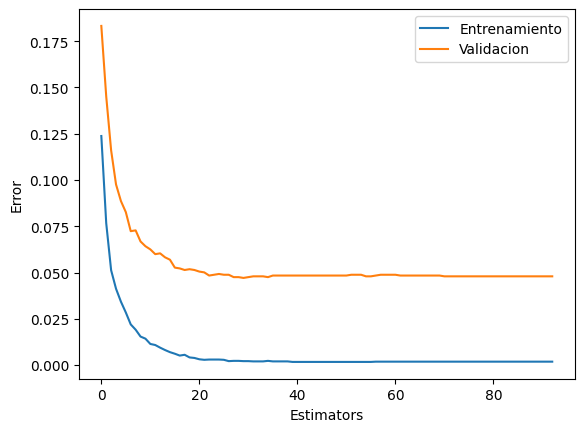

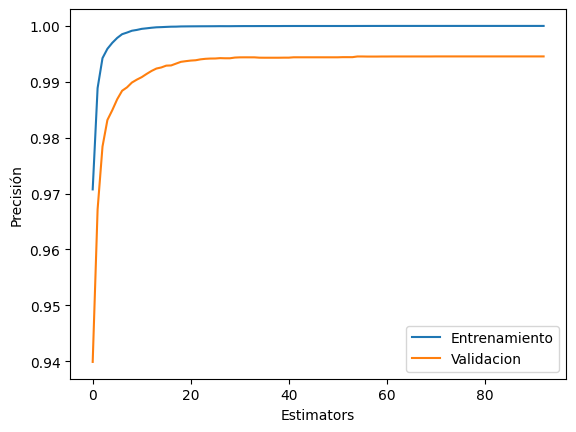

In [110]:
plt.figure(0)
plt.plot(results['validation_0']['merror'], label='Entrenamiento')
plt.plot(results['validation_1']['merror'], label='Validacion')
plt.xlabel('Estimators')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(results['validation_0']['auc'], label='Entrenamiento')
plt.plot(results['validation_1']['auc'], label='Validacion')
plt.xlabel('Estimators')
plt.ylabel('Precisión')
plt.legend()
plt.show()


En estas gráficas podemos observar como a partir de 40 estimadores tanto la función de coste como la precisión se empiezan a estabilizar, de hecho no se puede apreciar ninguna mejoría notable para el resto de estimadores. Por tanto no es necesario entrenar el modelo con más estimadores.
Podemos obtener el mejor número de estimadores con el atributo best_ntree_limit:

In [111]:
best_n_estimators = clf.best_ntree_limit
best_n_estimators

73

Estableceremos el número de estimadores en 73 ya que esto ayudará a reducir el tiempo de entrenamiento además de reducir el overfitting.

### Árbol de decisión con mejor resultado:

In [112]:
clf=xgb.XGBClassifier(objective='multi:softmax', num_class=4,
                    n_estimators = best_n_estimators, max_depth = best_max_depth, gamma = best_gamma,
                    min_child_weight=best_min_child_weight,
                    colsample_bytree=best_c_bytree, seed=RANDOM_STATE, eval_metric=["merror", "auc"],early_stopping_rounds=20, eta = best_eta)
    
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5549034216061453, early_stopping_rounds=20,
              enable_categorical=False, eta=0.4921666690308312,
              eval_metric=['merror', 'auc'], feature_types=None,
              gamma=1.4970364332334247, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=7.0, missing=nan,
              monotone_constraints=None, n_estimators=73, n_jobs=None,
              num_class=4, num_parallel_tree=None, ...)

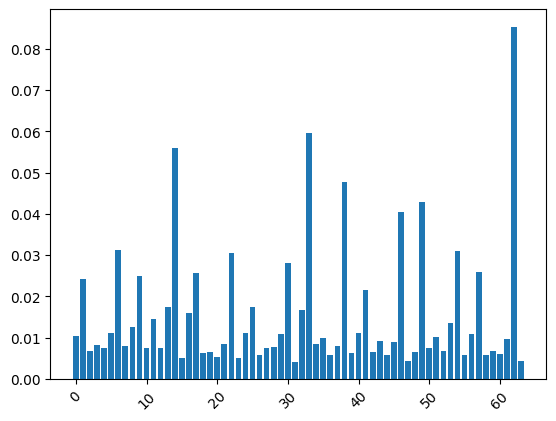

In [114]:
importance = clf.feature_importances_

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(rotation = 45) 
plt.show()

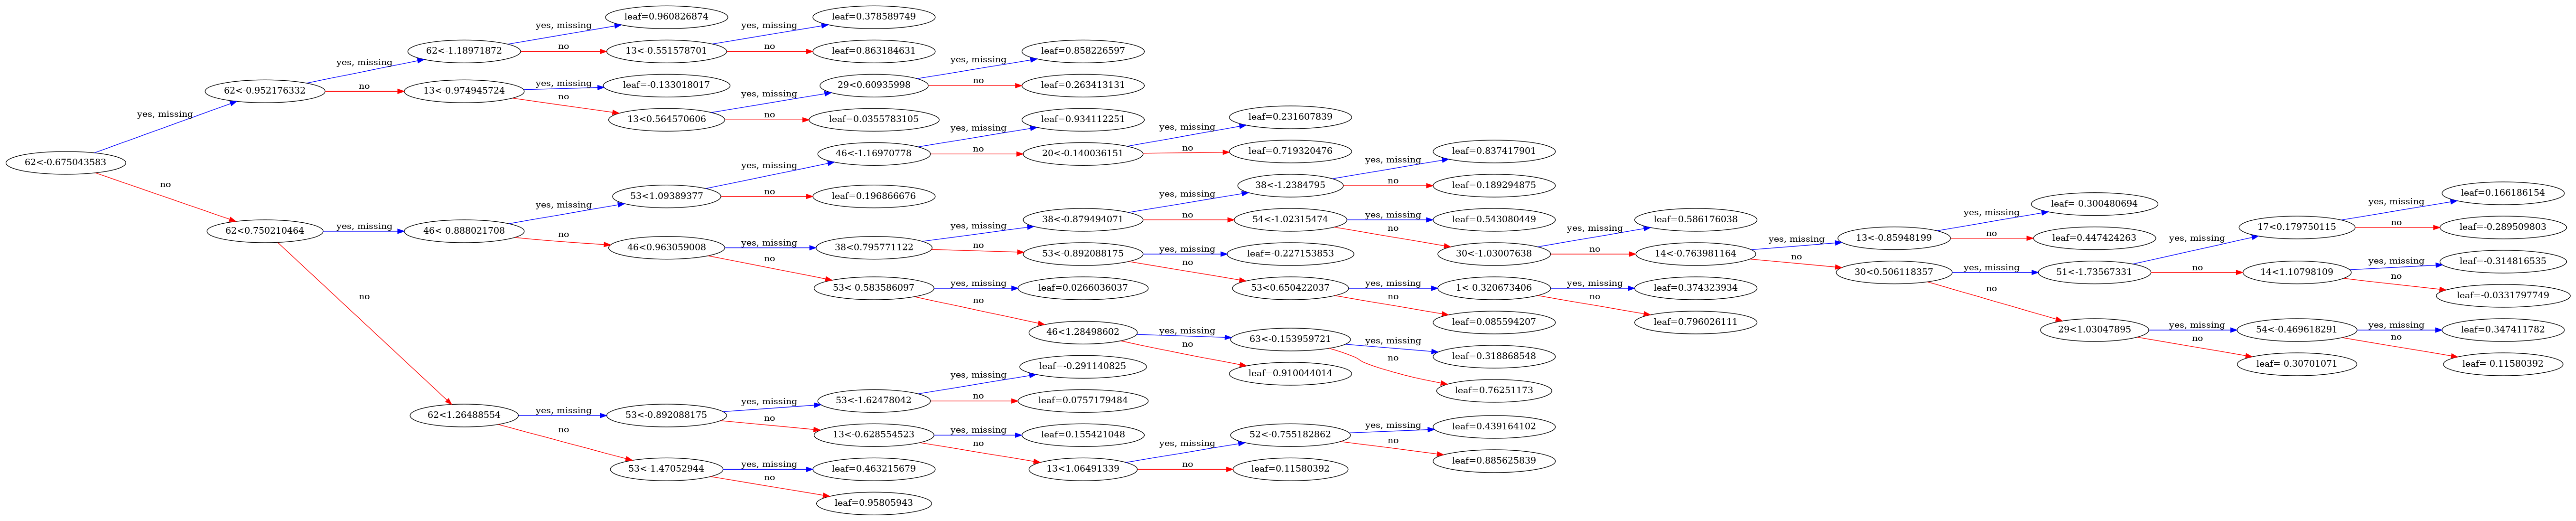

In [115]:
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(clf, ax=ax, num_trees=0, rankdir='LR')
plt.show()

### Estudio de la precisión:

In [116]:
accuracy = clf.score(X_test, y_test)
print("Precision de test: %.2f%%" % (accuracy * 100.0))

Precision de test: 95.55%


In [117]:
accuracy = clf.score(X_train, y_train)
print("Precision de train: %.2f%%" % (accuracy * 100.0))

Precision de train: 99.81%


In [118]:
accuracy = clf.score(X_val, y_val)
print("Precision de validacion: %.2f%%" % (accuracy * 100.0))

Precision de validacion: 95.21%


In [120]:
y_hat = clf.predict(X_test)
cr = classification_report(y_test, y_hat)
print (cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       582
           1       0.94      0.96      0.95       581
           2       0.96      0.94      0.95       589
           3       0.94      0.93      0.94       584

    accuracy                           0.96      2336
   macro avg       0.96      0.96      0.96      2336
weighted avg       0.96      0.96      0.96      2336



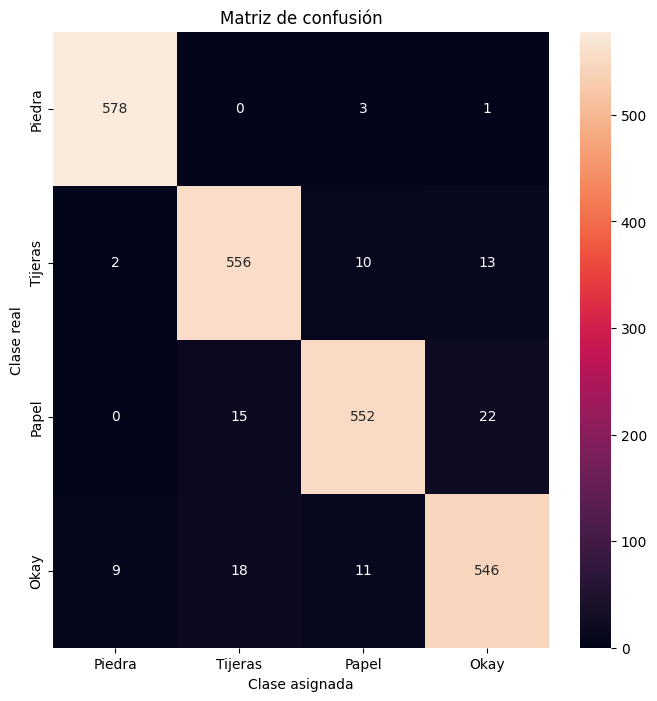

In [121]:
confusion_mtx = confusion_matrix(y_test, y_hat) 
labels = ["Piedra", "Tijeras", "Papel", "Okay"]

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, ax=ax, fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel("Clase asignada")
plt.ylabel("Clase real")
plt.title("Matriz de confusión")
plt.show()

# 8. Comparación de resultados <a class="anchor" id="Comparación-de-resultados"></a>

# 9. Conclusiones <a class="anchor" id="Conclusiones"></a>

# 10. Bibiliografía <a class="anchor" id="Bibliografía"></a>

- Ng, A. “C1_W3 classification + regularization.” Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W1 NN." Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W2 NN training + multiclass." Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W3 evaluation." Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W4 Decision Trees." Stanford. Disponible en el Campus Virtual.

- Amat Rodrigo, J. (2020) Regresión Lineal con python, Regresión lineal con python. Cienciadedatos.net. Disponible en: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html (Visitado: 28 de abril, 2023). 

- Amat Rodrigo, J. (2020) Regresión Lineal con python, Regresión lineal con python. Cienciadedatos.net. Disponible en: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html (Visitado: 28 de abril, 2023). 

- Redacción KeepCoding (2022) Función Softmax en tensorflow, Función softmax en TensorFlow . KeepCoding Bootcamps. Disponible en: https://keepcoding.io/blog/funcion-softmax-tensorflow/#Funcion_softmax_en_TensorFlow (Visitado: 1 de mayo, 2023). 

- Brownlee, J. (2021) Gentle introduction to the adam optimization algorithm for deep learning, MachineLearningMastery.com. machinelearningmastery.com. Disponible en: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ (Visitado: 1 de mayo, 2023). 

- Rendyk (2022) Tuning the hyperparameters and layers of neural network deep learning, Analytics Vidhya. Data Science Blogathon. Disponible en: https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/ (Visitado: 7 de mayo, 2023). 

- Natsume, Y. (2022) Bayesian optimization with python, Medium. Towards Data Science. Disponible en: https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec (Visitado: 7 de mayo, 2023). 

- Banerjee, P. (2020) A Guide on XGBoost hyperparameters tuning, Kaggle. Disponible en: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning (Visitado: 14 de mayo, 2023). 


### Figuras:

- Figura 1:
    Ng, A. Machine Learning , Machine learning. Disponible en: http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&amp;doc=exercises%2Fex5%2Fex5.html (Visitado: 1 de mayo, 2023). 

- Figuras 2 y 3:
    Ng, A. “C1_W3 classification + regularization.” Stanford. 